# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.metrics import classification_report_imbalanced
from imblearn.combine import SMOTEENN

# Read the CSV and Perform Basic Data Cleaning

In [3]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [4]:
# Load the data
file_path = Path('LoanStats_2019Q1.zip')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [5]:
# convert string values to integer
le = LabelEncoder()
df1 = df.copy()
df1["loan_status"] = le.fit_transform(df1["loan_status"])
df1["home_ownership"] = le.fit_transform(df1["home_ownership"])
df1["verification_status"] = le.fit_transform(df1["verification_status"])
df1["pymnt_plan"] = le.fit_transform(df1["pymnt_plan"])
df1["application_type"] = le.fit_transform(df1["application_type"])
df1["initial_list_status"] = le.fit_transform(df1["initial_list_status"])
df1["debt_settlement_flag"] = le.fit_transform(df1["debt_settlement_flag"])
df1["hardship_flag"] = le.fit_transform(df1["hardship_flag"])









# Create our features
X = df1.copy()
X = X.drop("loan_status", axis=1)


# # Create our target
y = df1["loan_status"]
y


0        1
1        1
2        1
3        1
4        1
        ..
68812    1
68813    1
68814    1
68815    1
68816    1
Name: loan_status, Length: 68817, dtype: int32

In [6]:
X.dtypes
X = X.select_dtypes(exclude=['object'])


In [7]:
# Check the balance of our target values
y.value_counts()
### target class "1" is low risk

1    68470
0      347
Name: loan_status, dtype: int64

In [8]:
# create testing and training datasets

X_train, X_test, y_train, y_test = train_test_split(X,
   y, random_state=1, stratify=y)

# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [9]:
# Resample the training data with the RandomOversampler
ros = RandomOverSampler()
X_oversample, y_oversample = ros.fit_resample(X_train, y_train)
y_oversample.value_counts()


1    51352
0    51352
Name: loan_status, dtype: int64

In [10]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver="lbfgs", random_state=1)
model.fit(X_oversample, y_oversample)
y_pred_oversample = model.predict(X_test)


In [11]:
# Calculated the balanced accuracy score

balanced_accuracy_score(y_test, y_pred_oversample)

0.6214208878736236

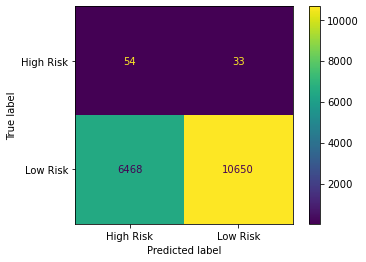

In [12]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred_oversample)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["High Risk", "Low Risk"])
disp.plot()

In [13]:
# Print the imbalanced classification report
CRI_oversample = (classification_report_imbalanced(y_test, y_pred_oversample, target_names=["High Risk", "Low Risk"]))
print(CRI_oversample)

                   pre       rec       spe        f1       geo       iba       sup

  High Risk       0.01      0.62      0.62      0.02      0.62      0.39        87
   Low Risk       1.00      0.62      0.62      0.77      0.62      0.39     17118

avg / total       0.99      0.62      0.62      0.76      0.62      0.39     17205



### SMOTE Oversampling

In [14]:
# Resample the training data with SMOTE
smo = SMOTE()
X_SMOTE, y_SMOTE = smo.fit_resample(X_train, y_train)
y_SMOTE.value_counts()


1    51352
0    51352
Name: loan_status, dtype: int64

In [15]:
# Train the Logistic Regression model using the resampled data
model.fit(X_SMOTE, y_SMOTE)
y_pred_SMOTE = model.predict(X_test)

In [16]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_SMOTE)

0.6423204451051726

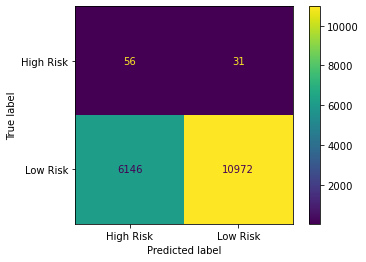

In [17]:
# Display the confusion matrix
cm1 = confusion_matrix(y_test, y_pred_SMOTE)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=["High Risk", "Low Risk"])
disp1.plot()

In [18]:
# Print the imbalanced classification report
CRI_SMOTE = (classification_report_imbalanced(y_test, y_pred_SMOTE, target_names=["High Risk", "Low Risk"]))
print(CRI_SMOTE)

                   pre       rec       spe        f1       geo       iba       sup

  High Risk       0.01      0.64      0.64      0.02      0.64      0.41        87
   Low Risk       1.00      0.64      0.64      0.78      0.64      0.41     17118

avg / total       0.99      0.64      0.64      0.78      0.64      0.41     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [19]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
CC = ClusterCentroids()
X_CC, y_CC = CC.fit_resample(X_train, y_train)
y_CC.value_counts()


0    260
1    260
Name: loan_status, dtype: int64

In [20]:
# Train the Logistic Regression model using the resampled data
model.fit(X_CC, y_CC)
y_pred_CC = model.predict(X_test)

In [21]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_CC)

0.5149248018822695

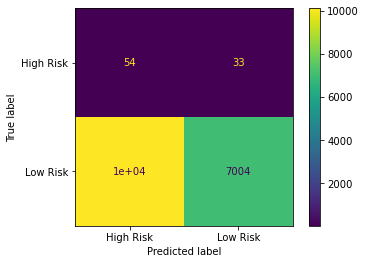

In [22]:
# Display the confusion matrix
cm2 = confusion_matrix(y_test, y_pred_CC)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["High Risk", "Low Risk"])
disp2.plot()

In [23]:
# Print the imbalanced classification report
CRI_CC = (classification_report_imbalanced(y_test, y_pred_CC, target_names=["High Risk", "Low Risk"]))
print(CRI_CC)

                   pre       rec       spe        f1       geo       iba       sup

  High Risk       0.01      0.62      0.41      0.01      0.50      0.26        87
   Low Risk       1.00      0.41      0.62      0.58      0.50      0.25     17118

avg / total       0.99      0.41      0.62      0.58      0.50      0.25     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [24]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
smoteenn = SMOTEENN()
X_smoteenn, y_smoteenn = smoteenn.fit_resample(X_train, y_train)
y_smoteenn.value_counts()


0    51349
1    46399
Name: loan_status, dtype: int64

In [25]:
# Train the Logistic Regression model using the resampled data
model.fit(X_smoteenn, y_smoteenn)
y_pred_smoteenn = model.predict(X_test)

In [29]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_smoteenn)

0.6344934350210103

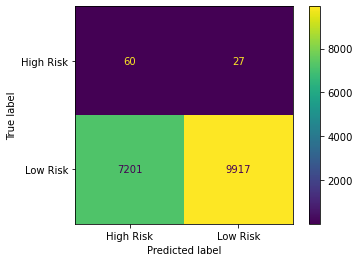

In [27]:
# Display the confusion matrix
cm3 = confusion_matrix(y_test, y_pred_smoteenn)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=["High Risk", "Low Risk"])
disp3.plot()


In [28]:
# Print the imbalanced classification report
CRI_smoteenn = (classification_report_imbalanced(y_test, y_pred_smoteenn, target_names=["High Risk", "Low Risk"]))
print(CRI_smoteenn)

                   pre       rec       spe        f1       geo       iba       sup

  High Risk       0.01      0.69      0.58      0.02      0.63      0.40        87
   Low Risk       1.00      0.58      0.69      0.73      0.63      0.40     17118

avg / total       0.99      0.58      0.69      0.73      0.63      0.40     17205

